In [112]:
from scipy import signal
from scipy.stats import norm
import numpy as np
from skimage.restoration import denoise_wavelet

def preprocess_vibration_data(data, sampling_frequency, lpf):
    # Step 1: Band-pass filtering
    # Design a Butterworth band-pass filter from 0.1 Hz to the Nyquist frequency
    b, a = signal.butter(4, lpf / (sampling_frequency / 2))
    
    # Apply the filter to the data
    data_filtered = signal.lfilter(b, a, data)
    

    # Step 3: Signal conditioning
    # Subtract the mean and divide by the standard deviation
    conditioned_data = (data_filtered - np.mean(data_filtered)) / np.std(data_filtered)
    rms= np.sqrt(np.mean(np.square(conditioned_data)))
    return conditioned_data, rms

In [61]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def apply_welch(sig, sr:int,nperseg:int,noverlap:int|None=None):
    if noverlap is None:
        noverlap = nperseg // 2
    f, Pxx_den = signal.welch(sig, sr, nperseg=nperseg, noverlap=noverlap)
    return f, Pxx_den



In [108]:
len(data['ACC3_Z'])/60

250.0

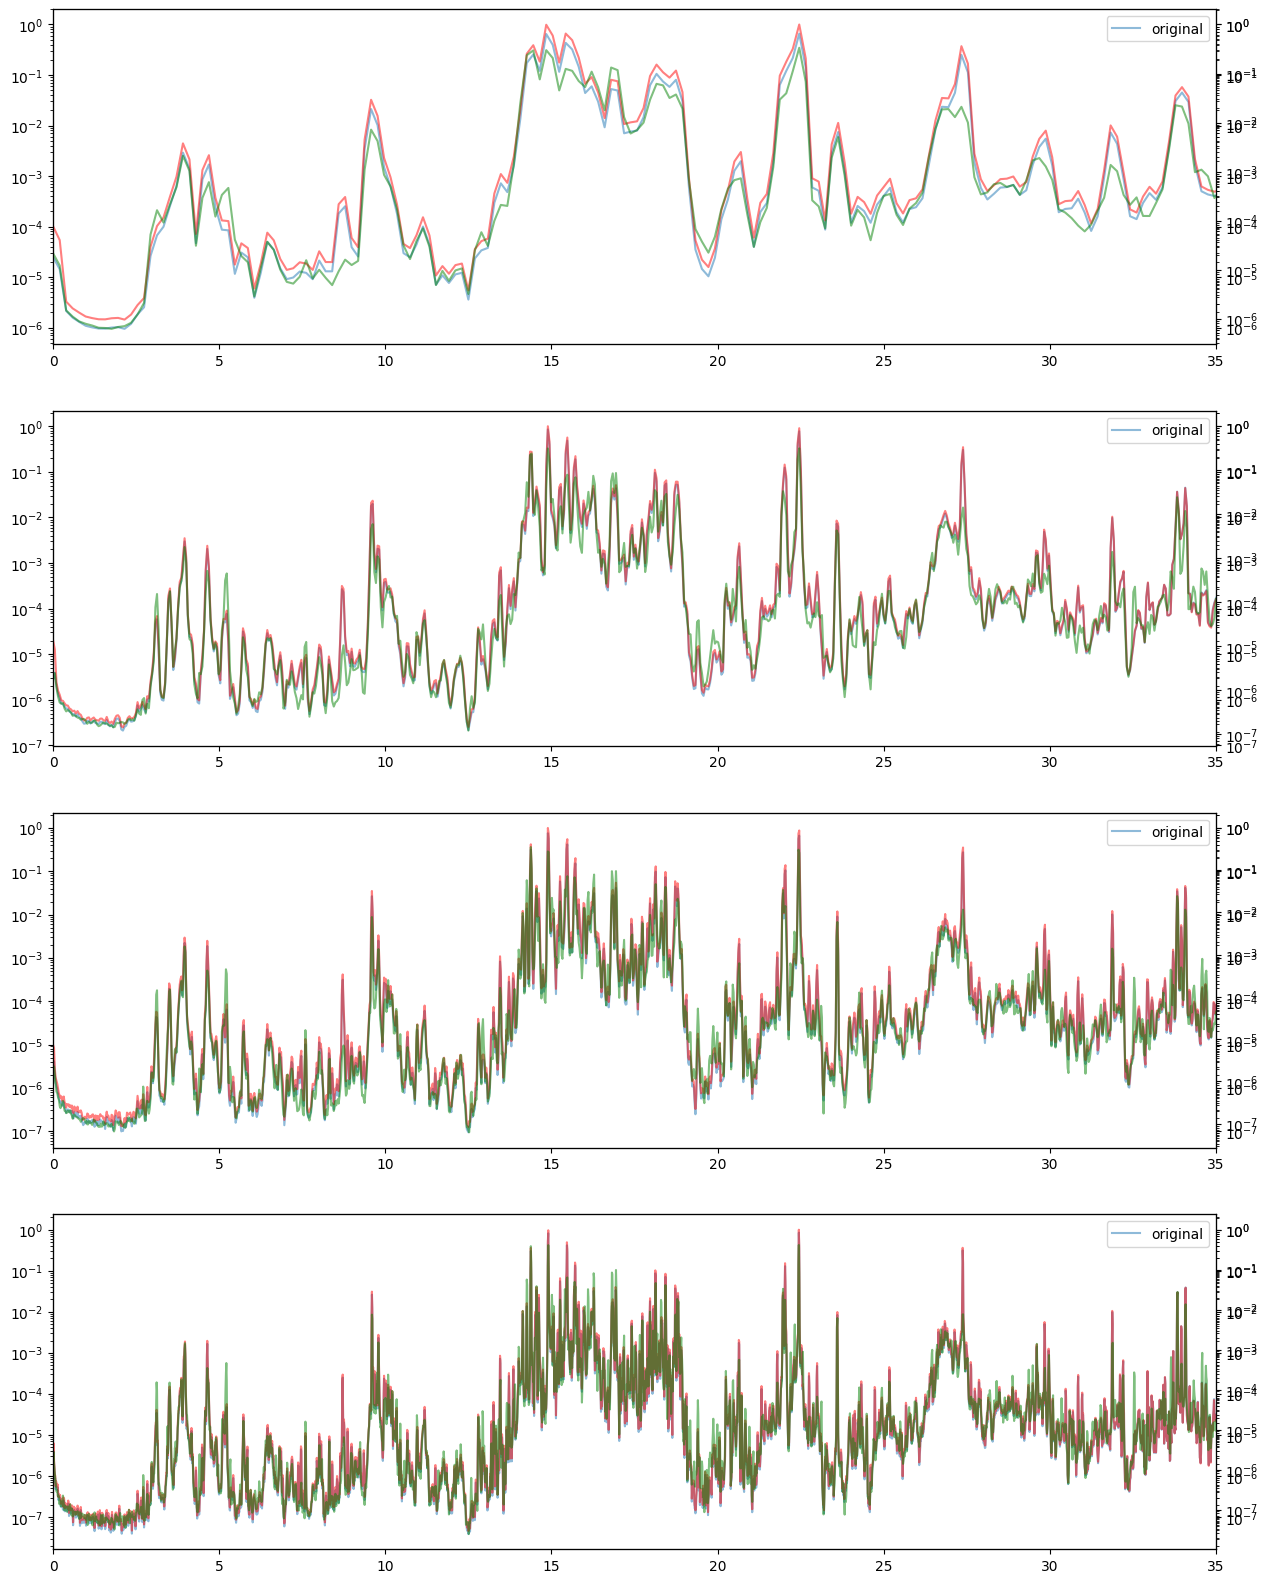

(0.0, 35.0)

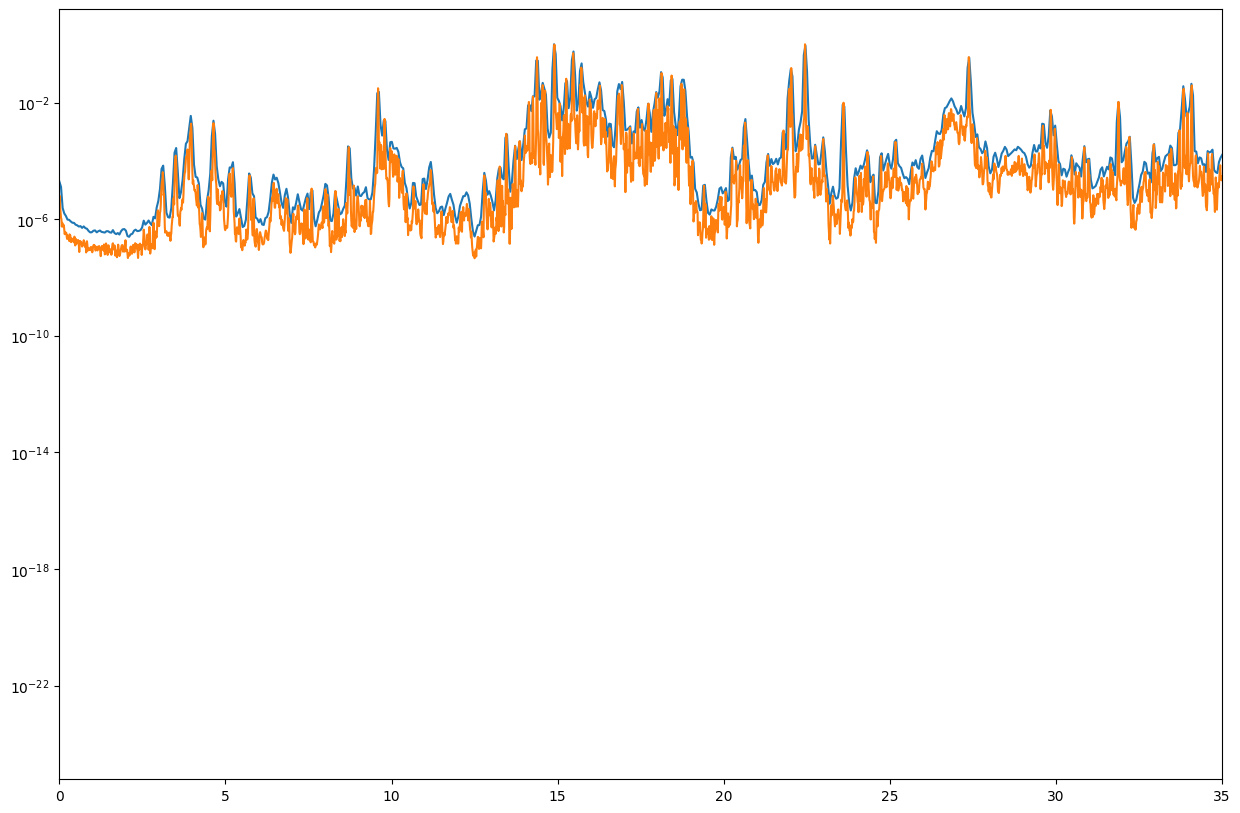

In [111]:
import sys
from pathlib import Path
from datetime import datetime, timedelta
import logging
import h5py
from VOOD.data import data_loader as dl
from config import settings
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
from scipy.signal import find_peaks


EPS = sys.float_info.epsilon
psd_frame = timedelta(minutes=10)
start_time = datetime(2022, 3, 30, 0, 0, 0)
end_time = datetime(2022, 6, 25, 0, 0, 0)
dt = datetime(2022, 4, 21, 0, 0, 0)
psd_frame = timedelta(minutes=10)
psd_step = timedelta(minutes=8)
sensor = dl.Sensor(name='ACC', location='MO04', data_type='TDD', format='.tdms')
loader = dl.DataLoader(sensor=sensor)
data = loader.get_data(dt, dt + psd_frame)
data2 = loader.get_data(dt + psd_step, dt + 2*psd_frame + psd_step)
time = np.arange(0, len(data['ACC3_Z'])) / 200

sig = data['ACC3_Z']
filtered_data, time = preprocess_vibration_data(sig, 250,50)
filtered_data_2 , time = preprocess_vibration_data(data2['ACC3_Z'], 250,50)

nperseg_list = [1024, 4096, 8192, 16384]
# Compute the PSD of the preprocessed data using the MUSIC method
spectre_no_preprocessing = dict()
for i in nperseg_list:
    spectre =apply_welch(sig, 200, i)
    spectre = spectre[0], spectre[1] / np.max(spectre[1])
    spectre_no_preprocessing[i] = spectre


spectre_preprocessing = dict()
for i in nperseg_list:

    spectre = apply_welch(filtered_data, 200, i)
    spectre = spectre[0], spectre[1] / np.max(spectre[1])
    spectre_preprocessing[i] = spectre

spectre_long = dict()
for i in nperseg_list:
    spectre = apply_welch(data2['ACC3_Z'], 200, i)
    spectre = spectre[0], spectre[1] / np.max(spectre[1])
    spectre_long[i] = spectre



fig, ax = plt.subplots(nrows=len(nperseg_list), figsize=(15, 20))
for i,nperseg in enumerate(nperseg_list):
    
    ax[i].plot(spectre_no_preprocessing[nperseg][0], spectre_no_preprocessing[nperseg][1], label='original',alpha=0.5)
    ax1 = ax[i].twinx()
    ax1.plot(spectre_preprocessing[nperseg][0], spectre_preprocessing[nperseg][1],'r', label='filtered',alpha=0.5)
    ax2 = ax[i].twinx()
    ax2.plot(spectre_long[nperseg][0], spectre_long[nperseg][1],'g', label='long',alpha=0.5)
    ax2.set_yscale('log')
    ax2.set_xlim(0, 35)
    ax1.set_yscale('log')
    ax1.set_xlim(0, 35)
    ax[i].set_yscale('log')
    ax[i].set_xlim(0, 35)
    bound_y = ax[i].get_ylim()
    ax1.set_ylim(bound_y)
    ax[i].legend()
plt.show()
plt.close()
plt.figure(figsize=(15, 10))
plt.plot(spectre_preprocessing[nperseg_list[1]][0], spectre_preprocessing[nperseg_list[1]][1], label='filtered')
plt.plot(spectre_preprocessing[nperseg_list[-1]][0], spectre_preprocessing[nperseg_list[-1]][1], label='original')
plt.yscale('log')
plt.xlim(0, 35)

In [90]:
data = data['ACC3_Z']

In [75]:
import numpy as np
from scipy import signal

def optimal_window_via_coherence(data, sampling_frequency, possible_windows):
    """
    This function computes the average coherence between the original data and the data after 
    Welch's method for different window sizes, and returns the window size that maximizes the average coherence.
    """
    max_avg_coherence = -np.inf
    optimal_window_size = None

    for window in possible_windows:
        f, Pxx = signal.welch(data, sampling_frequency, window=window)
        f, Cxy = signal.coherence(data, Pxx, fs=sampling_frequency, window=window, nperseg=window)
        avg_coherence = np.mean(Cxy)

        if avg_coherence > max_avg_coherence:
            max_avg_coherence = avg_coherence
            optimal_window_size = window

    return optimal_window_size


In [76]:
optimal_window_via_coherence( data, 200, [1024, 4096, 8192])

IndexError: tuple index out of range

/home/yacine/miniconda3/envs/OOD_env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 131072 is greater than input length  = 75000, using nperseg = 75000
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/yacine/miniconda3/envs/OOD_env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 262144 is greater than input length  = 75000, using nperseg = 75000
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/yacine/miniconda3/envs/OOD_env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 524288 is greater than input length  = 75000, using nperseg = 75000
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/yacine/miniconda3/envs/OOD_env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1048576 is greater than input length  = 75000, using nperseg = 75000
  warnings.warn('nperseg = {0:d} is gre

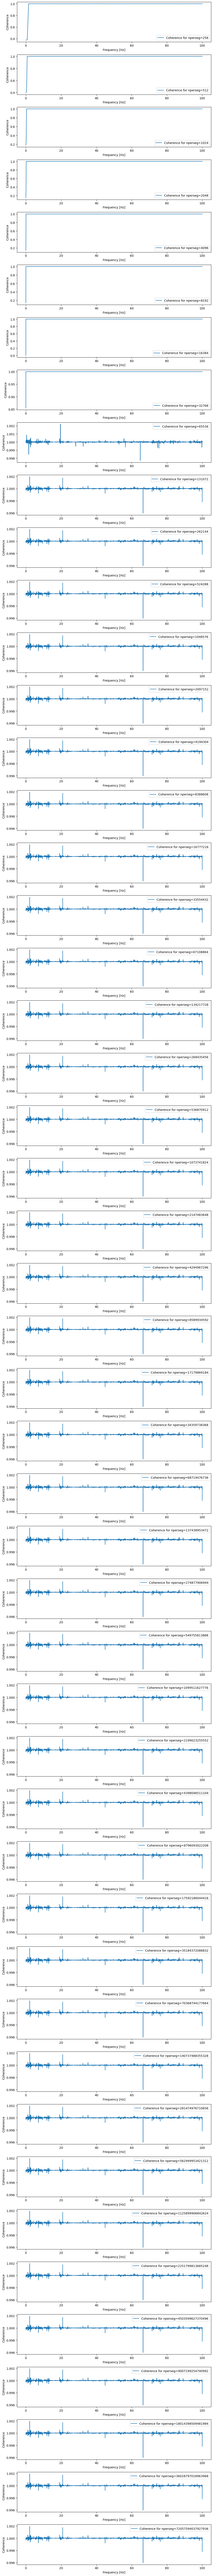

In [85]:
from scipy.signal import coherence
nperseg_list = [128*2**i for i in range(1, 50)]

fig, axs = plt.subplots(nrows=len(nperseg_list), figsize=(10, 120))

# Create a delayed version of the original signal
sig_delayed = np.concatenate(([0], sig[:-1]))
for i, nperseg in enumerate(nperseg_list):

    # Compute and plot the coherence
    freq, coh = coherence(sig, sig_delayed, fs=200, nperseg=nperseg)
    axs[i].plot(freq, coh, label=f'Coherence for nperseg={nperseg}')

    axs[i].set_xlabel('Frequency [Hz]')
    axs[i].set_ylabel('Coherence')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [88]:
data

Ellipsis

In [93]:
import numpy as np
from scipy.signal import welch
from scipy.stats import chi2

def calculate_bic(psd, nperseg, nobs):
    dof = nperseg // 2 + 1  # Degrees of freedom
    nparams = dof  # Number of parameters
    bic = -2 * np.sum(np.log(psd)) + nparams * np.log(nobs)
    return bic

# Assuming you have a signal 'data' sampled at fs = 200 Hz
fs = 200
data = data  # Your signal data

# Range of nperseg values to test
nperseg_values = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

# Calculate the PSD and BIC for each nperseg value
bic_values = []
psd_values = []
for nperseg in nperseg_values:
    f, psd = welch(data, fs=fs, nperseg=nperseg)
    bic = calculate_bic(psd, nperseg, len(data))
    bic_values.append(bic)
    psd_values.append(psd)

# Find the optimal nperseg based on the lowest BIC value
optimal_nperseg_index = np.argmin(bic_values)
optimal_nperseg = nperseg_values[optimal_nperseg_index]
optimal_psd = psd_values[optimal_nperseg_index]

# Print the optimal nperseg and its corresponding PSD
print("Optimal nperseg:", optimal_nperseg)
print("Optimal PSD:", optimal_psd)

# Optionally, you can perform statistical hypothesis testing to evaluate the significance
# of the improvement in BIC compared to the next best nperseg value
next_best_bic = bic_values[optimal_nperseg_index + 1]
dof = optimal_nperseg // 2 + 1
chi2_threshold = chi2.ppf(0.95, dof)  # Assuming a 95% confidence level
bic_difference = next_best_bic - bic_values[optimal_nperseg_index]
if bic_difference > chi2_threshold:
    print("The improvement in BIC is statistically significant.")
else:
    print("The improvement in BIC is not statistically significant.")

Optimal nperseg: 16
Optimal PSD: [4.8014041e-08 2.5091671e-07 2.0781933e-07 1.1865502e-07 1.7196842e-07
 3.2074279e-08 1.8889867e-08 1.6190215e-07 9.0686953e-08]
The improvement in BIC is statistically significant.
